In [1]:
# Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import rgb2hex
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
from scipy.stats import median_abs_deviation

/Users/Sara/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# Load data
data_vacuum_raw = pd.read_csv('data/vacuum.csv')
data_picking_raw = pd.read_csv('data/picking.csv')
data_walking_raw = pd.read_csv('data/walking.csv')

In [10]:
# Load data needed
data_vacuum_raw = pd.read_csv('data/vacuum.csv')[50:-100]
data_picking_raw = pd.read_csv('data/picking.csv')[50:-100]
data_walking_raw = pd.read_csv('data/walking.csv')[50:-100]

# Columns to pick
colnames_original = ["ACCELEROMETER X (m/s²)",
            "ACCELEROMETER Y (m/s²)",
            "ACCELEROMETER Z (m/s²)",
            "GYROSCOPE X (rad/s)",
            "GYROSCOPE Y (rad/s)",
            "GYROSCOPE Z (rad/s)",
            "GRAVITY X (m/s²)",
            "GRAVITY Y (m/s²)",
            "GRAVITY Z (m/s²)"]

# Pick relevant variables
data_vacuum = data_vacuum_raw[colnames_original]
data_picking = data_picking_raw[colnames_original]
data_walking = data_walking_raw[colnames_original]

# New column names
colnames = ['accelerometer_x',
            'accelerometer_y',
            'accelerometer_z',
            'gyroscope_x',
            'gyroscope_y',
            'gyroscope_z',
            'gravity_x',
            'gravity_y',
            'gravity_z']

colnames_dict = dict(zip(colnames_original, colnames))

# Changing column names
data_vacuum.rename(columns = colnames_dict, inplace = True)
data_picking.rename(columns = colnames_dict, inplace = True)
data_walking.rename(columns = colnames_dict, inplace = True)

/Users/Sara/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
# Standardize data
scl = StandardScaler()
data_vacuum = scl.fit_transform(data_vacuum)
data_picking = scl.fit_transform(data_picking)
data_walking = scl.fit_transform(data_walking)

In [14]:
# Function for merging observations

def merge_observations(data, seconds = 1):
    
    nr_to_merge = int(seconds/0.1)
    
    # Check if we can divide data evenly, otherwise cut data
    if (len(data) % nr_to_merge != 0):
        rows_to_remove = len(data) % nr_to_merge
        data = np.array(data[:-rows_to_remove])
        
    # Reshape into batches of observations to be merged
    data_reshaped = data.reshape(np.int(len(data)/nr_to_merge), nr_to_merge, data.shape[1])
    
    # Calculate agregated measures
    means = []
    stdevs = []
    mins = []
    maxs = []
    mads = []

    for i in range(len(data_reshaped)):
        means.append(data_reshaped[i].mean(axis = 0))
        stdevs.append(data_reshaped[i].std(axis = 0))
        mins.append(data_reshaped[i].min(axis = 0))
        maxs.append(data_reshaped[i].max(axis = 0))
        mads.append(median_abs_deviation(data_reshaped[0]))
        
    # Define columns names
    colnames_means = []
    colnames_stdevs = []
    colnames_mins = []
    colnames_maxs = []
    colnames_mads = []
    for i in range(len(colnames)):
        colnames_means.append(colnames[i] + '_mean')
        colnames_stdevs.append(colnames[i] + '_std')
        colnames_mins.append(colnames[i] + '_min')
        colnames_maxs.append(colnames[i] + '_max')
        colnames_mads.append(colnames[i] + '_mad')
    
    # Create dataframes
    df_mean = pd.DataFrame(stdevs, columns = colnames_means)
    df_std = pd.DataFrame(stdevs, columns = colnames_stdevs)
    df_min = pd.DataFrame(stdevs, columns = colnames_mins)
    df_max = pd.DataFrame(stdevs, columns = colnames_maxs)
    df_mad = pd.DataFrame(stdevs, columns = colnames_mads)
    
    # Merge dataframes
    dataframe_final = pd.concat([df_mean, df_std, df_min, df_max, df_mad], axis = 1)
    
    return dataframe_final

In [15]:
# Merge observations - 1 second per observation
data_vacuum_merge = merge_observations(data_vacuum)
data_picking_merge = merge_observations(data_picking)
data_walking_merge = merge_observations(data_walking)

In [16]:
# Label function for picking
def check_threshold(accelerometer_y):
    activity = 'walking'
    if np.abs(accelerometer_y) > 0.5:
        activity = 'picking'
    return activity

In [17]:
# Label data
data_picking_merge['activity'] = data_picking_merge['accelerometer_y_mean'].apply(check_threshold)
data_vacuum_merge['activity'] = 'vacuum'
data_walking_merge['activity'] = 'walking'

In [18]:
# Add to one dataframe
data = pd.concat([data_picking_merge,
                 data_vacuum_merge,
                 data_walking_merge], axis = 0)

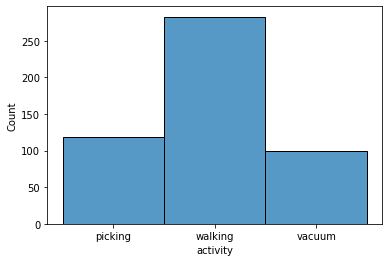

In [19]:
# Check distribution of activities
sns.histplot(x = 'activity', data = data)

In [20]:
# Separate labels and features
y = data['activity']
x = data.drop(labels = 'activity', axis = 1)

In [21]:
# Reduce dimensions to 2 by PCA
pca = PCA(n_components = 2, random_state = 42)
x_2 = pca.fit_transform(x)

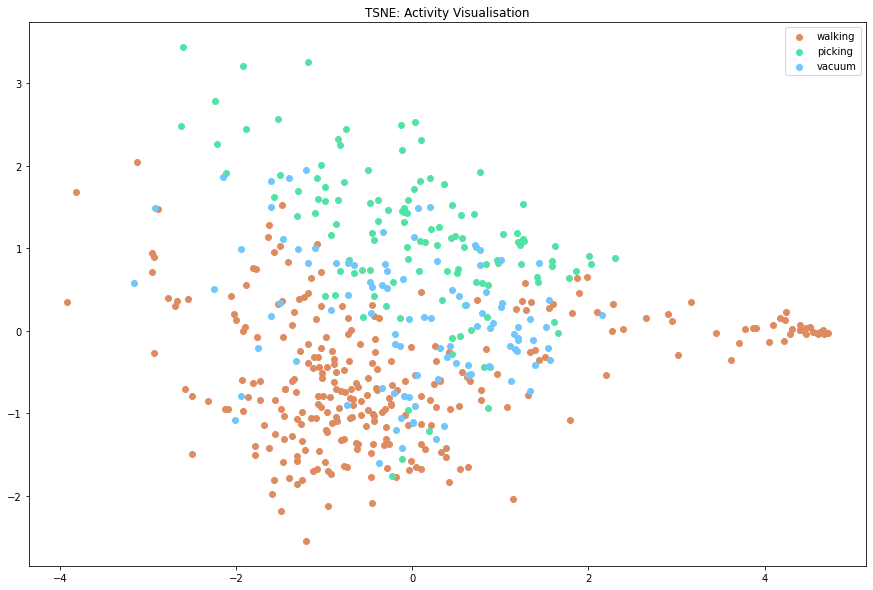

In [22]:
# Plot of the the data in 2 dimensions
fig, axarr = plt.subplots(1, 1, figsize =(15, 10))

n = y.unique().shape[0]
colors = ['#DF8B60', '#53E2A5', '#71C6FC']

# Plot each activity
for i, group in enumerate(y.value_counts().index):
    # Mask to separate sets
    mask = (y==group).values
    axarr.scatter(x=x_2[mask][:,0], y=x_2[mask][:,1], c=colors[i], label=group)
axarr.set_title('TSNE: Activity Visualisation')
axarr.legend()

plt.show()

In [23]:
# Reduce dimensions but keeping more variance
pca = PCA(n_components = 0.9, random_state = 42)
x_3 = pca.fit_transform(x)

# Transform
tsne = TSNE(random_state = 42)
x_transformed = tsne.fit_transform(x_3)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


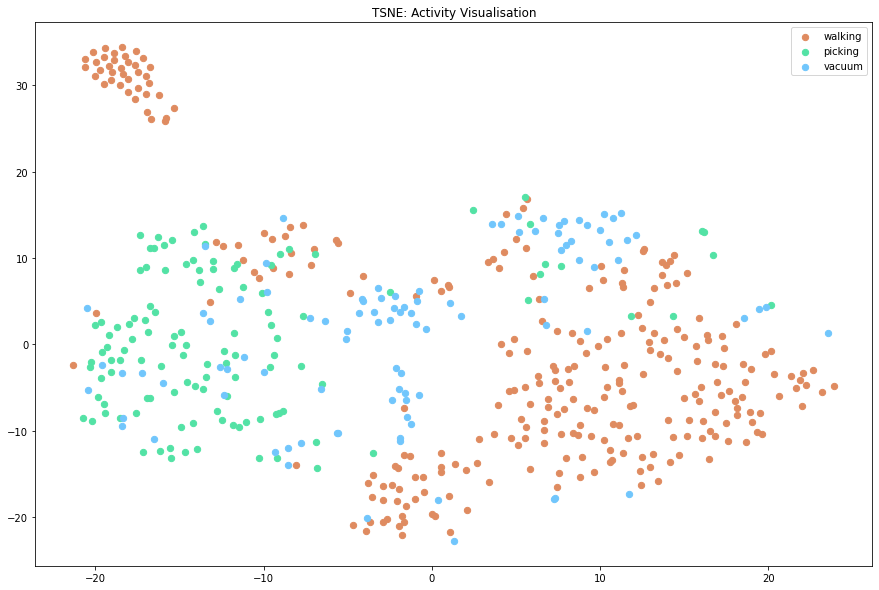

In [24]:
# Subplot
fig, axarr = plt.subplots(1, 1, figsize =(15, 10))

n = y.unique().shape[0]
colors = ['#DF8B60', '#53E2A5', '#71C6FC']

# Plot each activity
for i, group in enumerate(y.value_counts().index):
    # Mask to separate sets
    mask = (y==group).values
    axarr.scatter(x=x_transformed[mask][:,0], y=x_transformed[mask][:,1], c=colors[i], label=group, s = 40)
axarr.set_title('TSNE: Activity Visualisation')
axarr.legend()
plt.savefig('graf.eps')
plt.show()


In [25]:
# Splitting data into training and test set
enc = LabelEncoder()
label_encoded = enc.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(x, label_encoded, random_state = 42)

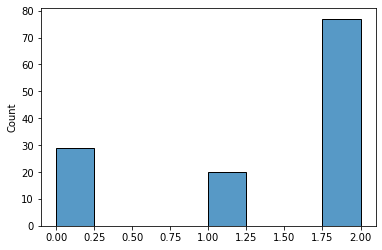

In [26]:
# Inspect distribution of labels in test set
sns.histplot(data = y_test)

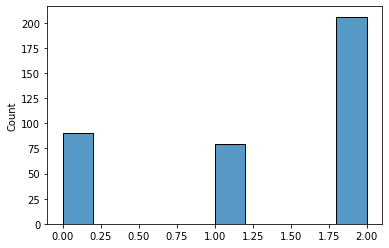

In [27]:
# Inspect distribution of labels in train set
sns.histplot(data = y_train)

In [28]:
# Specify and train model
lgbm = LGBMClassifier(n_estimators = 500, random_state = 42)
lgbm = lgbm.fit(X_train, y_train)

# Test model
score = accuracy_score(y_true = y_test, y_pred = lgbm.predict(X_test))
print('Accuracy on testset:\t{:.4f}\n'.format(score))

Accuracy on testset:	0.8889



Classes: 0: picking , 1: vacuum , 2: picking


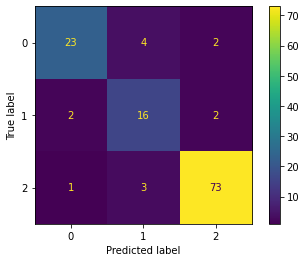

In [29]:
# Inspect the results for the different classes
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(lgbm, X_test, y_test)
print('Classes: 0:', enc.classes_[0], ', 1:', enc.classes_[1], ', 2:', enc.classes_[0])